In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = actions = np.array(['hello', 'thanks', 'iloveyou', 'No', 'yes', 'All the best'])
# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
# start_folder = 0

label_map = {label:num for num, label in enumerate(actions)}

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)

y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])




In [13]:
model.save('best_model1.keras')

Loaded model from 'best_model1.keras'
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - categorical_accuracy: 0.8889 - loss: 0.6584
Test Accuracy: 88.89%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Confusion Matrix:
[[3 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 2 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


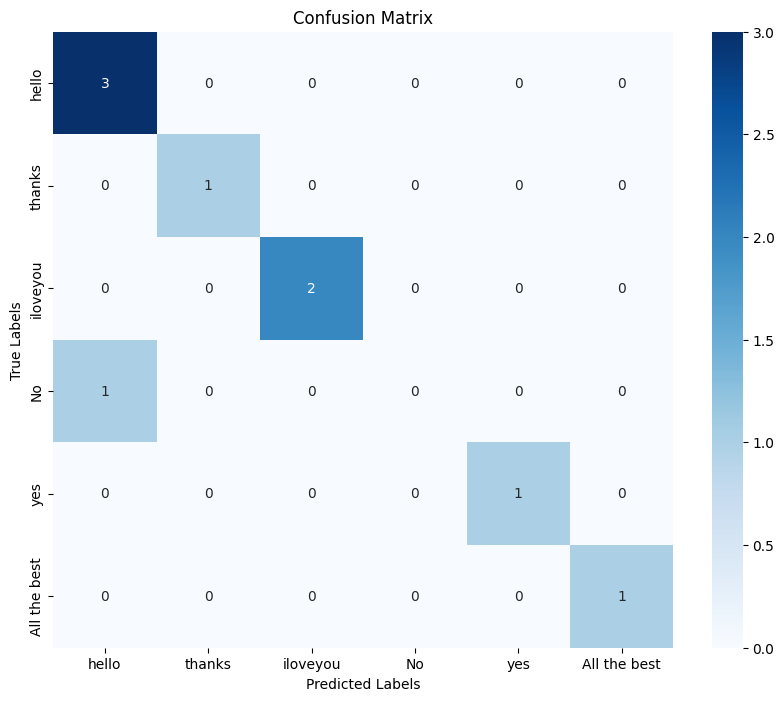

Classification Report:
              precision    recall  f1-score   support

       hello       0.75      1.00      0.86         3
      thanks       1.00      1.00      1.00         1
    iloveyou       1.00      1.00      1.00         2
          No       0.00      0.00      0.00         1
         yes       1.00      1.00      1.00         1
All the best       1.00      1.00      1.00         1

    accuracy                           0.89         9
   macro avg       0.79      0.83      0.81         9
weighted avg       0.81      0.89      0.84         9



C:\Users\praga\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\praga\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\praga\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [20]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'thanks', 'iloveyou', 'No', 'yes', 'All the best'])
no_sequences = 30  # Number of sequences per action
sequence_length = 30  # Frames per sequence
label_map = {label: num for num, label in enumerate(actions)}

# Load data
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Load the saved model
model = load_model('best_model1.keras')
print("Loaded model from 'best_model1.keras'")

# Evaluate on test data
eval_loss, eval_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {eval_acc * 100:.2f}%")

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=actions)
print("Classification Report:")
print(class_report)